In [493]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_8'

In [494]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [495]:
tf.random.set_seed(123)

In [496]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [497]:
type(ds_train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [498]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [499]:
type(ds_test)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [500]:
ds_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [501]:
type(ds_info)

tensorflow_datasets.core.dataset_info.DatasetInfo

In [502]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\German\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",


In [503]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [504]:
ds_train = ds_train.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
#ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [505]:
ds_test = ds_test.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128, drop_remainder=True)
#ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# 1. MLP

In [506]:
model = tf.keras.models.Sequential([
    # Input layer (28*28=784 neurons).
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 3 hidden fully-connected layers (simple feed-forward), each with 100 neurons and with ReLU activation.
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    # Output layer (10 neurons: one for each possible digit (target label) in the dataset: 0, 1, ..., 9).
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
468/468 [==============================] - 6s 6ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.9066 - val_loss: 0.1499 - val_sparse_categorical_accuracy: 0.9553
Epoch 2/5
468/468 [==============================] - 4s 6ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.1215 - val_sparse_categorical_accuracy: 0.9639
Epoch 3/5
468/468 [==============================] - 5s 8ms/step - loss: 0.0891 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.0945 - val_sparse_categorical_accuracy: 0.9711
Epoch 4/5
468/468 [==============================] - 4s 5ms/step - loss: 0.0673 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0819 - val_sparse_categorical_accuracy: 0.9733
Epoch 5/5
468/468 [==============================] - 4s 6ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0898 - val_sparse_categorical_accuracy: 0.9734


In [507]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_36 (Dense)            (None, 100)               78500     
                                                                 
 dense_37 (Dense)            (None, 100)               10100     
                                                                 
 dense_38 (Dense)            (None, 100)               10100     
                                                                 
 dense_39 (Dense)            (None, 10)                1010      
                                                                 
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________


In [508]:
import numpy as np

X_test = []
y_test = []
for image, label in ds_test.unbatch().as_numpy_iterator():
    X_test.append(image)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [509]:
X_test.shape

(9984, 28, 28, 1)

In [510]:
y_test.shape

(9984,)

In [511]:
y_pred = model.predict(X_test)

312/312 [==============================] - 1s 2ms/step


In [512]:
type(y_pred)

numpy.ndarray

In [513]:
y_pred.shape

(9984, 10)

In [514]:
y_pred[0]

array([-10.018439 ,   3.1146615,  15.4985695,   4.3998322,  -4.5493445,
        -2.5280757,  -6.208394 ,   1.602454 ,  -0.0682753,  -7.2109194],
      dtype=float32)

In [515]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [516]:
y_pred_classes[0]

2

In [517]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       978
           1       0.99      0.99      0.99      1133
           2       0.98      0.96      0.97      1030
           3       0.94      0.98      0.96      1009
           4       0.96      0.99      0.97       980
           5       0.98      0.96      0.97       888
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1027
           8       0.97      0.95      0.96       973
           9       0.98      0.96      0.97      1008

    accuracy                           0.97      9984
   macro avg       0.97      0.97      0.97      9984
weighted avg       0.97      0.97      0.97      9984



In [560]:
import matplotlib.pyplot as plt


def plot_bars(model_name, y_pred_):
    metric = 'f1-score'

    report = classification_report(y_test, y_pred_, output_dict=True)
    keys = range(10)
    values = [report[str(k)][metric] for k in keys]

    plt.figure(figsize=(4, 5))

    plt.bar(keys, values)
    plt.axhline(np.asarray(values).mean(), c='green', linestyle='dashed')  # average
    plt.axhline(1., c='cyan', linestyle='dashed')  # perfect

    plt.xticks(keys)
    plt.yticks(np.arange(0., 1.05, 0.05))
    plt.xlabel('digit')
    plt.ylabel(metric)
    plt.title('Handwritten Digits Recognition: ' + model_name)

    plt.show()

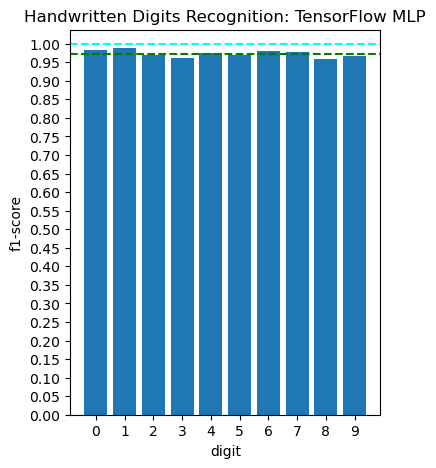

In [561]:
plot_bars('TensorFlow MLP', y_pred_classes)

In [520]:
def plot_learning_curve(history_):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history_.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xticks(range(len(history_.history)))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xticks(range(len(history_.history)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.show()

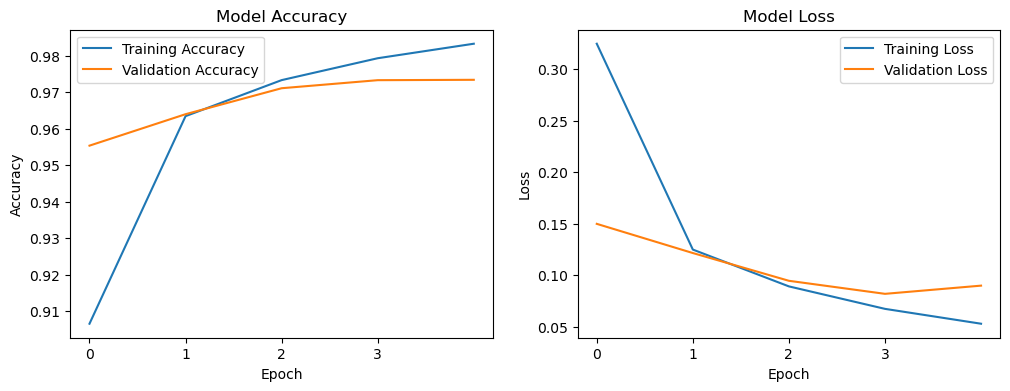

In [521]:
plot_learning_curve(history)

In [522]:
from PIL import Image

In [523]:
image = Image.open(f'{dir}/test_1.png').convert('L').resize((28, 28))  # grayscale 28x28
image

In [524]:
import numpy as np

In [525]:
image_arr = np.array(image) / 256.

In [526]:
type(image_arr)

numpy.ndarray

In [527]:
image_arr.shape

(28, 28)

In [528]:
image_arr

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [529]:
image_arr = np.expand_dims(image_arr, axis=0)

In [530]:
type(image_arr)

numpy.ndarray

In [531]:
image_arr.shape

(1, 28, 28)

In [532]:
image_arr

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [533]:
predictions = model.predict(image_arr)

1/1 [==============================] - 0s 143ms/step


In [534]:
type(predictions)

numpy.ndarray

In [535]:
predictions.shape

(1, 10)

In [536]:
predictions

array([[-7.958382 , 11.047284 , -3.2564607, -2.6083012,  2.1373389,
        -2.5359   , -3.6563704,  3.251723 , -1.7818193,  1.920436 ]],
      dtype=float32)

In [537]:
probabilities = tf.nn.softmax(predictions)

In [538]:
type(probabilities)

tensorflow.python.framework.ops.EagerTensor

In [539]:
probabilities

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[5.5674541e-09, 9.9933904e-01, 6.1330320e-07, 1.1726477e-06,
        1.3494994e-04, 1.2606976e-06, 4.1114680e-07, 4.1128587e-04,
        2.6798100e-06, 1.0863582e-04]], dtype=float32)>

In [540]:
probabilities = probabilities.numpy()

In [541]:
type(probabilities)

numpy.ndarray

In [542]:
probabilities.shape

(1, 10)

In [543]:
probabilities

array([[5.5674541e-09, 9.9933904e-01, 6.1330320e-07, 1.1726477e-06,
        1.3494994e-04, 1.2606976e-06, 4.1114680e-07, 4.1128587e-04,
        2.6798100e-06, 1.0863582e-04]], dtype=float32)

In [544]:
y_pred = np.argmax(probabilities)

In [545]:
type(y_pred)

numpy.int64

In [546]:
y_pred

1

In [547]:
def simple_classify_one(test_pic_file):
    image = Image.open(f'{dir}/{test_pic_file}').convert('L').resize((28, 28))  # grayscale 28x28
    image_arr = np.array(image) / 256.
    image_arr = np.expand_dims(image_arr, axis=0)
    predictions = model.predict(image_arr)
    probabilities = tf.nn.softmax(predictions)
    y_pred = np.argmax(probabilities)
    y_pred_confidence = float(probabilities[0][y_pred])
    print(f'Classification: {y_pred}. Confidence: {round(y_pred_confidence * 100., 2)}%')

In [548]:
simple_classify_one('test_1.png')

1/1 [==============================] - 0s 28ms/step
Classification: 1. Confidence: 99.93%


In [549]:
simple_classify_one('test_3.png')

1/1 [==============================] - 0s 26ms/step
Classification: 3. Confidence: 100.0%


In [550]:
simple_classify_one('test_8.png')

1/1 [==============================] - 0s 25ms/step
Classification: 8. Confidence: 93.73%


In [551]:
simple_classify_one('test_9.png')

1/1 [==============================] - 0s 25ms/step
Classification: 3. Confidence: 98.11%


# 2. CNN